In [52]:
# Importing dependencies
import pandas as pd
from pathlib import Path
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Reading in the data
file_path = Path('cleaned_data.csv')
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,sex,age,education,smokingStatus,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,BMI,heartRate,glucose,CHDRisk,MAP
0,0,1.0,39,4,0.0,0,0,0,0,0,195,26.97,80,77,0,82.000000
1,1,0.0,46,2,0.0,0,0,0,0,0,250,28.73,95,76,0,94.333333
2,2,1.0,48,1,1.0,20,0,0,0,0,245,25.34,75,70,0,95.833333
3,3,0.0,61,3,1.0,30,0,0,1,0,225,28.58,65,103,1,113.333333
4,4,0.0,46,3,1.0,23,0,0,0,0,285,23.10,85,85,0,99.333333


In [30]:
# Separating target variables and features
y = df['CHDRisk']
X = df.drop(columns='CHDRisk')

In [31]:
y.value_counts()

CHDRisk
0    3084
1     553
Name: count, dtype: int64

In [32]:
# Using RandomOverSampler to balance the target variable conditions
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(df.drop('CHDRisk', axis=1), df['CHDRisk'])

y = y_resampled
X = X_resampled

In [33]:
y.value_counts()

CHDRisk
0    3084
1    3084
Name: count, dtype: int64

In [34]:
# Splitting the data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=1, stratify=y)

In [35]:
X_train.shape

(4626, 15)

In [36]:
y_train.shape

(4626,)

In [37]:
# Scaling the feature variables
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [38]:
# Instantiating the model
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [39]:
# Training the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [40]:
# Making predictions with the testing data
predictions = rf_model.predict(X_test_scaled)

In [41]:
# Creating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy and recall scores
acc_score = accuracy_score(y_test, predictions)

In [42]:
# Printing the results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,725,46
Actual 1,9,762


Accuracy Score : 0.9643320363164721
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       771
           1       0.94      0.99      0.97       771

    accuracy                           0.96      1542
   macro avg       0.97      0.96      0.96      1542
weighted avg       0.97      0.96      0.96      1542



In [43]:
# Calculating feature importances and listing by importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.1484422873433366, 'age'),
 (0.14306151658581787, 'MAP'),
 (0.1171437700602865, 'Unnamed: 0'),
 (0.11686414413912805, 'BMI'),
 (0.11129729068821301, 'glucose'),
 (0.1109702175553044, 'totChol'),
 (0.09078007175207665, 'heartRate'),
 (0.04673864553220841, 'cigsPerDay'),
 (0.0355421844720268, 'education'),
 (0.027927129983988386, 'prevalentHyp'),
 (0.024429713814772262, 'sex'),
 (0.01302231781873123, 'smokingStatus'),
 (0.006353919158081198, 'BPMeds'),
 (0.005989783572344316, 'diabetes'),
 (0.0014370075236843094, 'prevalentStroke')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

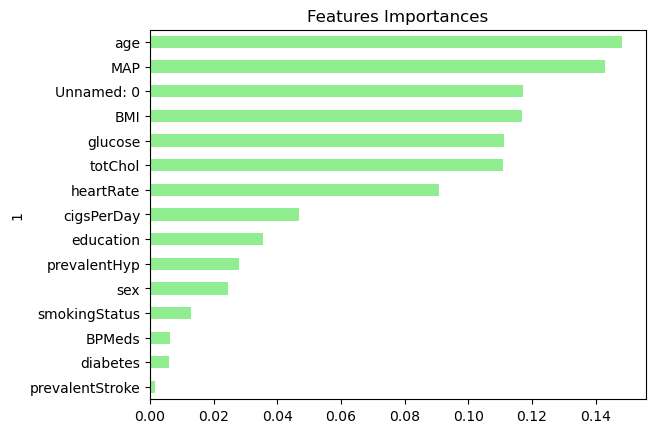

In [44]:
# Visualizing the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

Using k-fold cross-validation to ensure model is not overfitting

In [45]:
# Setting up k-fold cross-validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)

In [46]:
X_resampled_scaled = scaler.fit_transform(X_resampled)
#Perform cross-validation
cv_results = cross_val_score(rf_model, X_resampled_scaled, y_resampled, cv=kf, scoring='accuracy')

# Print cross-validation results
print(f'Cross-validation results (accuracy): {cv_results}')
print(f'Mean cross-validation accuracy: {cv_results.mean()}')
print(f'Standard deviation of cross-validation accuracy: {cv_results.std()}')

Cross-validation results (accuracy): [0.97163695 0.97001621 0.96839546 0.96836983 0.97972425]
Mean cross-validation accuracy: 0.9716285403694458
Standard deviation of cross-validation accuracy: 0.004224031036334012


In [53]:
# Class Distribution Before and After Balancing
def plot_class_distribution(y_before, y_after):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.countplot(x=y_before, ax=ax[0])
    ax[0].set_title('Class Distribution Before Balancing')
    sns.countplot(x=y_after, ax=ax[1])
    ax[1].set_title('Class Distribution After Balancing')
    plt.show()

In [54]:
# Confusion Matrix Heatmap:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [49]:
# Feature Importances:
def plot_feature_importances(importances, feature_names):
    importances_df = pd.DataFrame(sorted(zip(importances, feature_names), reverse=True), columns=['Importance', 'Feature'])
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
    plt.title('Feature Importances')
    plt.show()


In [50]:
# ROC Curve:
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Cross-validation Results:
def plot_cv_results(cv_results):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=cv_results, orient='h')
    plt.title('Cross-validation Results (Accuracy)')
    plt.xlabel('Accuracy')
    plt.show()

In [51]:
# Saving the model
import pickle

# Example model object, replace with your actual model
# rf_model = ...

# Specify the file name
pickle_file = "rf_model.pkl"

# Open the file in binary write mode and save the model
with open(pickle_file, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Model saved to {pickle_file}")

Model saved to rf_model.pkl
